In [1]:
from scipy.io import loadmat
import numpy as np
# from scipy.optimize import minimize
from datetime import datetime
now = datetime.now

import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import pickle

import json
from scipy import fft
from scipy.signal.windows import hann
from copy import deepcopy
from scipy.stats import chi2

In [34]:
SaveFitFigs = True
# SaveFitData = True
dpiN = 1000
dark_plots = False
n_sig = 8
n_print_sigfigs = 4
if dark_plots:
    dark='darkbg/'
    q = mpl.rc_params_from_file('matplotlibrc_dark')
else:
    dark = 'whitebg/'
    mpl.rcParams.update(mpl.rcParamsDefault)
SavePlotDir_Exp2  = '../Results/2021-12-21_foursigfigs/Exp2/'+dark+'FittingFigs/'
# SaveDataDir_Exp2  = '../Results/2021-11-16/Exp2/'+'Pickles/'
LoadDataDir_Exp2 = '../Results/2021-12-20/Exp2/Pickles/'#SaveDataDir_Exp2 # The other notebook stored the pickle in the same folder
if SaveFitFigs:
    if not os.path.exists(SavePlotDir_Exp2):
        os.makedirs(SavePlotDir_Exp2)
# if SaveFitData:
#     if not os.path.exists(SaveDataDir_Exp2):
#         os.makedirs(SaveDataDir_Exp2)


In [35]:
if dark_plots:
    mpl.rcParams.update(q)
    %matplotlib inline
    mpl.rcParams.update({
                    #'legend.borderpad': 0.3,
                    #'legend.borderaxespad': 0.25,
#                     'legend.columnspacing': 0.6,
#                     'legend.handlelength': 0.7,
                    #'legend.handleheight': 0.4,
                    #'legend.handletextpad': 0.2,
#                     'legend.labelspacing': 0.45,
#                     'text.usetex': True,
                    'font.size':13,
                    })
else:
    %matplotlib inline
    # mpl.rcParams.update(mpl.rcParamsDefault)
    font = {
    #    'weight' : 'normal',
       'size'   : 15,
       'family': 'Times New Roman'}
    plt.rc('font', **font)
#     mpl.rcParams.update({'font.family':'serif'})

In [4]:
%load_ext autoreload

In [5]:
from B_calc_script import FieldAtAnyLocation
from B_calc_script import signif

In [6]:
%autoreload 2

# Load data

In [7]:
Exp2_data_filename = LoadDataDir_Exp2+'Exp2_cut_averaged_data.pk'

In [8]:
with open(Exp2_data_filename,'rb') as file_obj:
    Exp2_data_cut = pickle.load(file_obj)

## Load parameters ##

In [9]:

nu = 5

In [10]:
with open('../Params/Exp2_dimensions_and_locations.json', 'r') as fp:
    params_dims_locs = json.load(fp)

In [11]:
params_dims_locs

{'D_wheel_sensor': 8,
 'D_wheel_sample': 0.2,
 'rotor_dims': {'height': 10,
  'outer_radius': 18.9992,
  'inner_radius': 15.0114,
  'hole_radius': 2.49936,
  'bar_width': 7.01},
 'AW_location': {'coordinate': 'cartesian',
  'location': "np.array([0.5*(rotor_dims['outer_radius']+rotor_dims['inner_radius']),0,rotor_dims['height']/2+D_wheel_sensor])"},
 'AV_location': {'coordinate': 'cartesian',
  'location': "np.array([-rotor_dims['outer_radius']-D_wheel_sensor,0,0])"},
 '3He locations': {'1': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample,0])"},
  '2': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample + 0.07,0])"},
  '3': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample-0.07,-1.2])"},
  '4': {'coordinate': 'cartesian',
   'location': "np.array([0,-rotor_dims['outer_radius']-D_wheel_sample,1])"}}}

In [12]:
rtr_dims = params_dims_locs['rotor_dims']

In [13]:
for key in rtr_dims:
    rtr_dims[key]= signif(rtr_dims[key],n_sig)

In [14]:
He_sample_locations =deepcopy(params_dims_locs['3He locations'])
for Hekey in He_sample_locations.keys():
    string_to_parse = params_dims_locs['3He locations'][Hekey]['location']
    He_sample_locations[Hekey]['location']=eval(string_to_parse.replace('rotor_dims','rtr_dims').replace('D_wheel_sample','params_dims_locs[\'D_wheel_sample\']'))


In [15]:
# with open('../Params/'+'FittedDipoles_{}Hz_'.format(nu)+'3sources.pk','rb') as filehandle:
#     Exp2_Opt_Params_3_sources = pickle.load(filehandle)
# Exp2_Opt_Params_3_sources=Exp2_Opt_Params_3_sources.tolist()

In [16]:
with open('../Params/'+'FittedDipoles_{}Hz_'.format(nu)+'3sources.json','r',encoding = 'utf-8') as filehandle:
    Exp2_Opt_Params_3_sources = json.loads(filehandle.read())

In [17]:
Exp2_Opt_Params_3_sources

[13.3564915713363,
 8.909598710197937,
 4.546578898649152,
 13.907117209493078,
 -18.56630617249708,
 -21.0558150317366,
 15.02461376917935,
 274.12392162292207,
 -4.992384424761422,
 13.007017942583083,
 -39.84480935029292,
 21.9526772425048,
 15.145107219676024,
 93.50479555158148,
 -3.9134322372727146,
 38.028723875130396,
 -30.298070983448746,
 -33.49399183272222,
 -34.933303129103344,
 24.43020109213642,
 7.135859881874096,
 -34.81125319662422,
 93.557750090174]

In [18]:
Exp2_Opt_Params_3_sources_noDC_noBar = Exp2_Opt_Params_3_sources[:-5]
Exp2_Opt_Params_3_sources_zeroDC = Exp2_Opt_Params_3_sources_noDC_noBar+ [0,0,0] + [Exp2_Opt_Params_3_sources[-1]]

In [19]:
# with open('../Params/Params_4sources.pk','rb') as filehandle:
#     Exp2_Opt_Params_4_sources = pickle.load(filehandle)

# Calculate field at sample location #

In [20]:
Sample_settings = {
    'rotor dimensions':rtr_dims,
    'sensor locations':He_sample_locations,
    # 'bar location':0,
#     'DC shifts':[DC_shift_AVx,DC_shift_AVy,DC_shift_AWy,DC_shift_AWz]
#    'deltaB':1 #picoTesla
}

In [21]:


Data_At_Sample = {
    'theta':np.concatenate([Exp2_data_cut['theta avg'][nu]
    # ,360+Exp2_data_cut['theta avg'][nu]
    ]), 
    #theta positive for ac, negative for clockwise
    'B':{
        '3He 1':{
            'Z':np.array([]),
            'Y':np.array([]),
            'X':np.array([])
        },
    }
            }

In [37]:
# nowtext = now().strftime("%Y%m%d%H%M")

nowtext = '_15font'
fitplotfilename = SavePlotDir_Exp2+'FittedData_at_sample_{}Hz'.format(nu)+nowtext+'.png'
# fitdatafilename = SaveDataDir_Exp2+'FittedData_at_sample_{}Hz'.format(nu)+nowtext+'.pk'

Exp2_optimization_settings = {
    'print':True,
    'number of sources':3,
    'location dimensions':3,
    'moment dimensions':3,
    'location coordinate system':'polar',
    'moment coordinate system':'polar',
    # 'chi tolerance':n_sig+1,
    'optimize DC shifts':True,
    'optimize bar location':True,
    'significant figures':n_sig
}

Exp2_plot_settings = {
    'plot':True,
#     'memo':'{} Hz (AV X&Y inverted)'.format(nu),
    # 'memo':'{} Hz'.format(nu),
    'doubleplot':False,
    'saveplot':SaveFitFigs,
    'dpi':dpiN,
    'figname':fitplotfilename,
    'print sigfigs':n_print_sigfigs
}
Exp2_save_settings ={
    'save fit data':False,
    # 'fit data filename':fitdatafilename
}

Exp2_all_settings = {
    'experiment settings':Sample_settings,
    'data':Data_At_Sample,
    'optimization settings':Exp2_optimization_settings,
    'plot settings':Exp2_plot_settings,
    'save settings':Exp2_save_settings
    
}

Exp2_Opt_Params = Exp2_Opt_Params_3_sources_zeroDC
field_at_sample = FieldAtAnyLocation(Exp2_Opt_Params,Exp2_all_settings)

# FFT Field at Sample Location

In [23]:
n_reps  = 50

In [24]:
Field_At_He_location_for_FFT = {}
Field_At_He_location_for_FFT['time'] = Data_At_Sample['theta']/360/nu
Field_At_He_location_for_FFT['B time domain'] = {}
Field_At_He_location_for_FFT['B freq domain'] = {}
numsamples = n_reps*Field_At_He_location_for_FFT['time'].size
binsize = Field_At_He_location_for_FFT['time'][2] - Field_At_He_location_for_FFT['time'][1]
Field_At_He_location_for_FFT['freq']= fft.rfftfreq(n = numsamples,d=binsize)

In [25]:
for Hekey in field_at_sample.keys():
    Field_At_He_location_for_FFT['B time domain'][Hekey] = {}
    Field_At_He_location_for_FFT['B freq domain'][Hekey] = {}
    for axiskey in field_at_sample[Hekey].keys():
        Field_At_He_location_for_FFT['B time domain'][Hekey][axiskey] = np.tile(field_at_sample[Hekey][axiskey],n_reps)
        Field_At_He_location_for_FFT['B freq domain'][Hekey][axiskey] = 4*fft.rfft(Field_At_He_location_for_FFT['B time domain'][Hekey][axiskey]*hann(numsamples),norm = "forward")


In [26]:
indnu = (np.abs(Field_At_He_location_for_FFT['freq']-nu)<0.5*nu)
ind11nu = (np.abs(Field_At_He_location_for_FFT['freq']-11*nu)<0.5*nu)
FFT_amp_table = {}
# FFT_amp_table['frequency'] .append(nu)
FFT_amp_table[nu] = {}
FFT_amp_table[11*nu] = {}
B_max_table = {}
for Hekey in Field_At_He_location_for_FFT['B freq domain'].keys():

    FFT_amp_table[nu][Hekey] = {}
    FFT_amp_table[11*nu][Hekey] = {}
    B_max_table[Hekey] = {}
    for axiskey in Field_At_He_location_for_FFT['B freq domain'][Hekey].keys():
        FFT_amp_table[nu][Hekey][axiskey] = np.abs(Field_At_He_location_for_FFT['B freq domain'][Hekey][axiskey][indnu]).max()
        FFT_amp_table[11*nu][Hekey][axiskey] = np.abs(Field_At_He_location_for_FFT['B freq domain'][Hekey][axiskey][ind11nu]).max()
        B_max_table[Hekey][axiskey] = np.abs(Field_At_He_location_for_FFT['B freq domain'][Hekey][axiskey]).max()

In [27]:
print("FFT Amplitudes calculated at locations inside He spheroid")
for freq in FFT_amp_table.keys():
    print('{} Hz'.format(freq), end = "\n")
    print("-------------------")
    print("Axis  |", end = " ")
    for Hekey in FFT_amp_table[freq].keys():
        print('Sensor {} |'.format(Hekey), end = " ")
    print("\n")
    for axiskey in FFT_amp_table[freq][Hekey].keys():
        print("  "+axiskey+"   |",end="")
        for Hekey in FFT_amp_table[freq].keys():
            print("   {:0.1f}   |".format(FFT_amp_table[freq][Hekey][axiskey]),end="")
        print("\n")
    print("-------------------")

FFT Amplitudes calculated at locations inside He spheroid
5 Hz
-------------------
Axis  | Sensor 1 | Sensor 2 | Sensor 3 | Sensor 4 | 

  X   |   9.4   |   9.7   |   6.4   |   10.6   |

  Y   |   61.0   |   62.6   |   53.2   |   57.4   |

  Z   |   31.3   |   31.2   |   61.7   |   14.1   |

-------------------
55 Hz
-------------------
Axis  | Sensor 1 | Sensor 2 | Sensor 3 | Sensor 4 | 

  X   |   2.1   |   2.3   |   1.4   |   3.4   |

  Y   |   4.4   |   4.6   |   4.5   |   3.7   |

  Z   |   2.9   |   3.0   |   7.1   |   2.5   |

-------------------


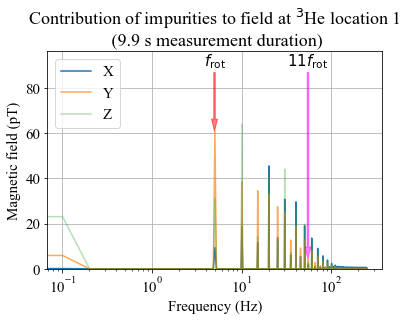

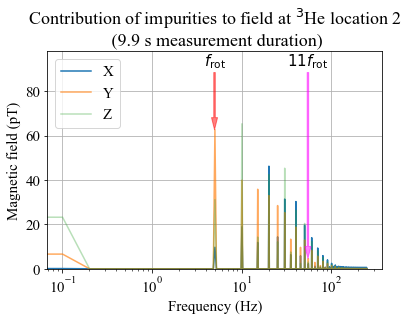

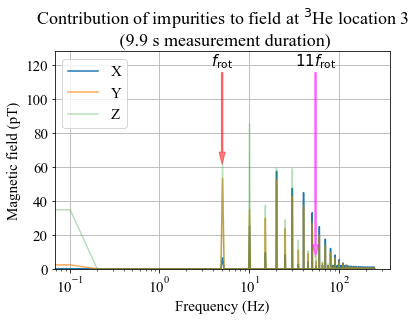

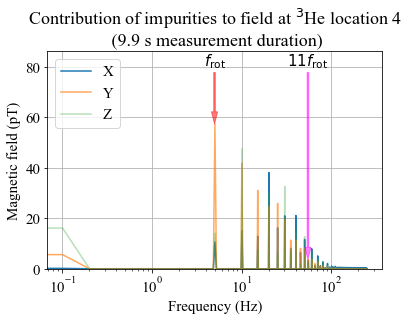

In [28]:
for Hekey in Field_At_He_location_for_FFT['B freq domain'].keys():
    plt.figure()
    i_num = 0
    B_max = 0
    max_at_nu = 0
    max_at_11nu = 0
    for axiskey in Field_At_He_location_for_FFT['B freq domain'][Hekey].keys():
        plt.semilogx(Field_At_He_location_for_FFT['freq']
        ,np.abs(Field_At_He_location_for_FFT['B freq domain'][Hekey][axiskey])
        ,label = axiskey
        ,alpha = 1-i_num/3)
        i_num +=1
        B_max = max(B_max, B_max_table[Hekey][axiskey])
        max_at_nu = max(max_at_nu, FFT_amp_table[nu][Hekey][axiskey])
        max_at_11nu = max(max_at_11nu, FFT_amp_table[11*nu][Hekey][axiskey])
    plt.annotate('$f_\mathrm{rot}$',xy = (nu,max_at_nu),xytext=(nu,B_max*1.4),\
                    arrowprops=dict(color='red',alpha=0.5,width = 1.5,headwidth=6, shrink=0.),\
                horizontalalignment='center')
    plt.annotate('$11f_\mathrm{rot}$',xy = (11*nu,max_at_11nu),xytext=(11*nu,B_max*1.4),\
                    arrowprops=dict(color='fuchsia',alpha=0.5,width = 1.5,headwidth=6,shrink=0.),\
                horizontalalignment='center')

    plt.ylim(0,B_max*1.5)
    plt.xlabel('Frequency (Hz)')
    plt.title('Contribution of impurities to field at $^3$He location {}\n ({:0.1f} s measurement duration)'.format(Hekey,n_reps*Field_At_He_location_for_FFT['time'][-1]))
    plt.ylabel('Magnetic field (pT)')
    plt.grid()
    plt.legend(loc = 'upper left')
    if SaveFitFigs:
        plt.savefig(SavePlotDir_Exp2+'BFFT_at_sample_{}.png'.format(Hekey),bbox_inches = 'tight',dpi = dpiN)

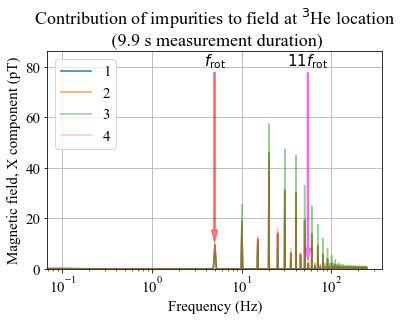

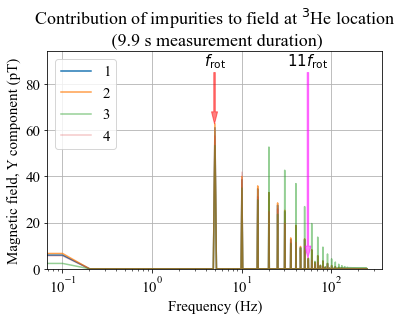

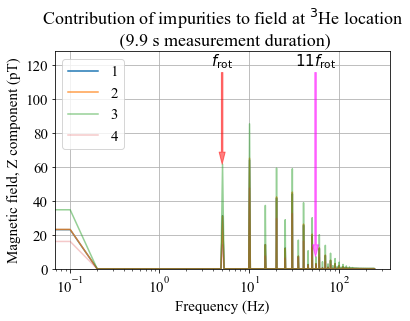

In [29]:
for axiskey in Field_At_He_location_for_FFT['B freq domain']['1'].keys():
    plt.figure()
    i_num = 0
    B_max = 0
    max_at_nu = 0
    max_at_11nu = 0
    for Hekey in Field_At_He_location_for_FFT['B freq domain'].keys():
        plt.semilogx(Field_At_He_location_for_FFT['freq']
        ,np.abs(Field_At_He_location_for_FFT['B freq domain'][Hekey][axiskey])
        ,label = Hekey
        ,alpha = 1-i_num/4)
        i_num +=1
        B_max = max(B_max, B_max_table[Hekey][axiskey])
        max_at_nu = max(max_at_nu, FFT_amp_table[nu][Hekey][axiskey])
        max_at_11nu = max(max_at_11nu, FFT_amp_table[11*nu][Hekey][axiskey])
    plt.annotate('$f_\mathrm{rot}$',xy = (nu,max_at_nu),xytext=(nu,B_max*1.4),\
                    arrowprops=dict(color='red',alpha=0.5,width = 1.5,headwidth=6, shrink=0.),\
                horizontalalignment='center')
    plt.annotate('$11f_\mathrm{rot}$',xy = (11*nu,max_at_11nu),xytext=(11*nu,B_max*1.4),\
                    arrowprops=dict(color='fuchsia',alpha=0.5,width = 1.5,headwidth=6,shrink=0.),\
                horizontalalignment='center')

    plt.ylim(0,B_max*1.5)
    plt.xlabel('Frequency (Hz)')
    plt.title('Contribution of impurities to field at $^3$He location \n ({:0.1f} s measurement duration)'.format(n_reps*Field_At_He_location_for_FFT['time'][-1]))
    plt.ylabel('Magnetic field, {} component (pT)'.format(axiskey))
    plt.grid()
    plt.legend(loc = 'upper left')
    if SaveFitFigs:
        plt.savefig(SavePlotDir_Exp2+'BFFT_at_sample_{}_component.png'.format(axiskey),bbox_inches = 'tight',dpi = dpiN)